# Lab 2: Trajectory Planning and Workspace Analysis
This notebook loads the Stanford robot model, sets parameters, and performs workspace analysis, inverse kinematics, and trajectory planning using three distinct methods.


In [1]:
# Import libraries
import numpy as np
import roboticstoolbox as rtb
from spatialmath import SE3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load Stanford robot model with Lab 1 parameters
robot = rtb.models.DH.Stanford()

# Set dynamic parameters from Lab 1
masses = [10.0, 8.0, 5.0, 2.0, 1.0, 0.5]
centers = [[0,0,0], [-0.2,0,0.1], [0,-0.1,0], 
          [0,0,0.05], [0,0,0], [0,0,0.02]]
inertias = [[0.05,0.1,0.05,0,0,0], [0.04,0.08,0.04,0,0,0],
           [0.02,0.03,0.02,0,0,0], [0.005]*3+[0,0,0],
           [0.001]*3+[0,0,0], [0.0005,0.0005,0.0002,0,0,0]]

for i in range(6):
    robot.links[i].m = masses[i]
    robot.links[i].r = centers[i]
    robot.links[i].I = inertias[i]


## Initial Configuration and Forward Kinematics
Sets an arbitrary initial joint configuration and computes the initial end-effector pose.


In [2]:
q0 = np.array([0, 0, 0.2, 0, 0, 0])  # Initial joint configuration
T_initial = robot.fkine(q0)
print("Initial end-effector pose:\n", T_initial)


Initial end-effector pose:
    0         1         0         0         
  -1         0         0         0.1337    
   0         0         1         0.612     
   0         0         0         1         



## Workspace Construction and Visualization
Samples random joint configurations within joint limits to visualize the reachable workspace.


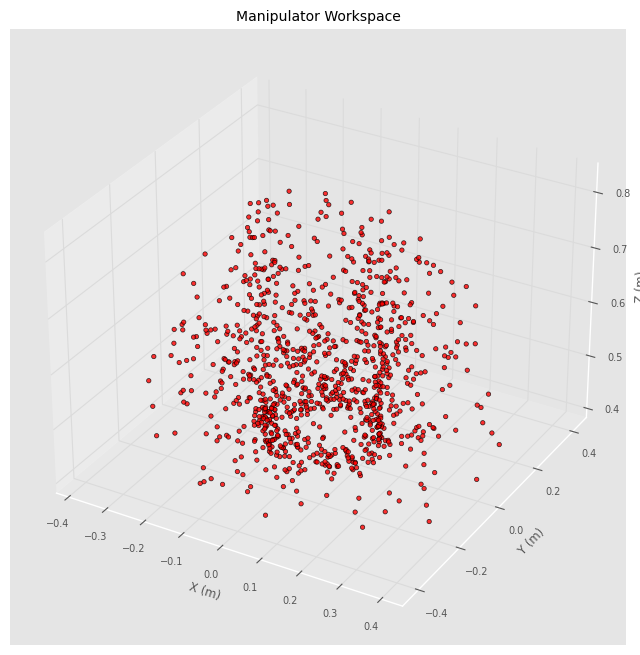

In [3]:
num_samples = 1000
workspace_points = []

for _ in range(num_samples):
    q_sample = np.random.uniform(
        low=[-np.pi, -np.pi/2, 0, -np.pi, -np.pi, -np.pi],
        high=[np.pi, np.pi/2, 0.412, np.pi, np.pi, np.pi]
    )
    Te = robot.fkine(q_sample)
    workspace_points.append(Te.t)

workspace_points = np.array(workspace_points)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(workspace_points[:,0], workspace_points[:,1], workspace_points[:,2],
           s=10, alpha=0.8, c='red', edgecolors='k', linewidths=0.5)
ax.set_title('Manipulator Workspace')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()


## Inverse Kinematics
Selects a target pose within the workspace and solves for the corresponding joint configuration.


In [4]:
target_pose = SE3(0.5, 0.2, 0.3) * SE3.OA([0, 0, 1], [1, 0, 0])
ik_sol = robot.ikine_LM(target_pose, q0=q0, mask=[1,1,1,1,1,1])
qf = ik_sol.q
print("IK solution (degrees):", np.degrees(qf))

T_final = robot.fkine(qf)
print("Target pose:\n", target_pose)
print("Achieved pose:\n", T_final)


IK solution (degrees): [  7.42597015 -77.88248764 -30.5697716   58.1637476  165.81713773
  58.95304145]
Target pose:
    0         0         1         0.5       
   1         0         0         0.2       
   0         1         0         0.3       
   0         0         0         1         

Achieved pose:
   -2.67e-11  5.207e-11  1         0.5       
   1         2.597e-12  2.67e-11  0.2       
  -2.597e-12  1        -5.207e-11  0.3       
   0         0         0         1         



## Trajectory 1: Quintic Polynomial in Joint Space
Generates a smooth quintic polynomial trajectory between initial and final joint configurations.


In [5]:
traj1 = rtb.jtraj(q0, qf, 50)


## Trajectory 2: Cartesian Straight-Line Trajectory with IK
Generates a Cartesian straight-line path between initial and final end-effector poses, then solves IK at each waypoint to get joint-space trajectory.


In [6]:
# Generate Cartesian trajectory (50 steps)
T_se = rtb.ctraj(T_initial, T_final, 50)

# Solve IK for each Cartesian waypoint
q_traj2 = []
q_prev = q0
for T in T_se:
    sol = robot.ikine_LM(T, q0=q_prev, mask=[1,1,1,1,1,1])
    q_traj2.append(sol.q)
    q_prev = sol.q  # warm start next IK with previous solution

q_traj2 = np.array(q_traj2)

# Create a simple trajectory object with approximate velocities and accelerations
class SimpleTrajectory:
    def __init__(self, q):
        self.q = q
        self.qd = np.gradient(q, axis=0)
        self.qdd = np.gradient(self.qd, axis=0)
        self.n = q.shape[1]

traj2 = SimpleTrajectory(q_traj2)


## Trajectory 3: Multi-Segment Rotational Interpolation
Creates a multi-segment trajectory through via-points using `mstraj` with distinct intermediate joint positions.


In [8]:
# Define via points for the trajectory
via_points = np.array([
    [0, 0, 0.2, 0, 0, 0],    # Initial configuration
    [0.5, 0.5, 0.3, 0, 0, 0],  # Intermediate point
    [1, 1, 0.4, 0, 0, 0]     # Final configuration
])

# Generate multi-segment trajectory using mstraj
traj3_raw = rtb.mstraj(
    viapoints=via_points,
    dt=0.1,
    qdmax=0.5,
    tacc=0.5
)

# Compute velocity and acceleration numerically
qd = np.gradient(traj3_raw.q, axis=0) / 0.1  # approximate velocity (rad/s)
qdd = np.gradient(qd, axis=0) / 0.1         # approximate acceleration (rad/s^2)

# Create a simple wrapper class to hold all trajectory data
class TrajectoryWrapper:
    def __init__(self, q, qd, qdd):
        self.q = q
        self.qd = qd
        self.qdd = qdd

traj3 = TrajectoryWrapper(traj3_raw.q, qd, qdd)




## Plotting Function
Plots joint positions, velocities, and accelerations for a given trajectory.


In [9]:
def plot_trajectory(traj, title):
    plt.figure(figsize=(14, 10))
    time_steps = range(traj.q.shape[0])
    
    # Positions
    plt.subplot(3, 1, 1)
    for j in range(traj.q.shape[1]):
        plt.plot(time_steps, traj.q[:, j], label=f'Joint {j+1}', linewidth=2)
    plt.title(f'{title} - Joint Positions')
    plt.ylabel('Position (rad or m)')
    plt.legend()
    plt.grid(True)
    
    # Velocities
    plt.subplot(3, 1, 2)
    if hasattr(traj, 'qd') and traj.qd is not None:
        for j in range(traj.qd.shape[1]):
            plt.plot(time_steps, traj.qd[:, j], label=f'Joint {j+1}', linewidth=2)
        plt.title('Joint Velocities')
        plt.ylabel('Velocity (rad/s or m/s)')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Velocity data not available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')
    
    # Accelerations
    plt.subplot(3, 1, 3)
    if hasattr(traj, 'qdd') and traj.qdd is not None:
        for j in range(traj.qdd.shape[1]):
            plt.plot(time_steps, traj.qdd[:, j], label=f'Joint {j+1}', linewidth=2)
        plt.title('Joint Accelerations')
        plt.ylabel('Acceleration (rad/s² or m/s²)')
        plt.xlabel('Time step')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Acceleration data not available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


## Plot All Trajectories
Visualizes the three distinct trajectories for comparison.


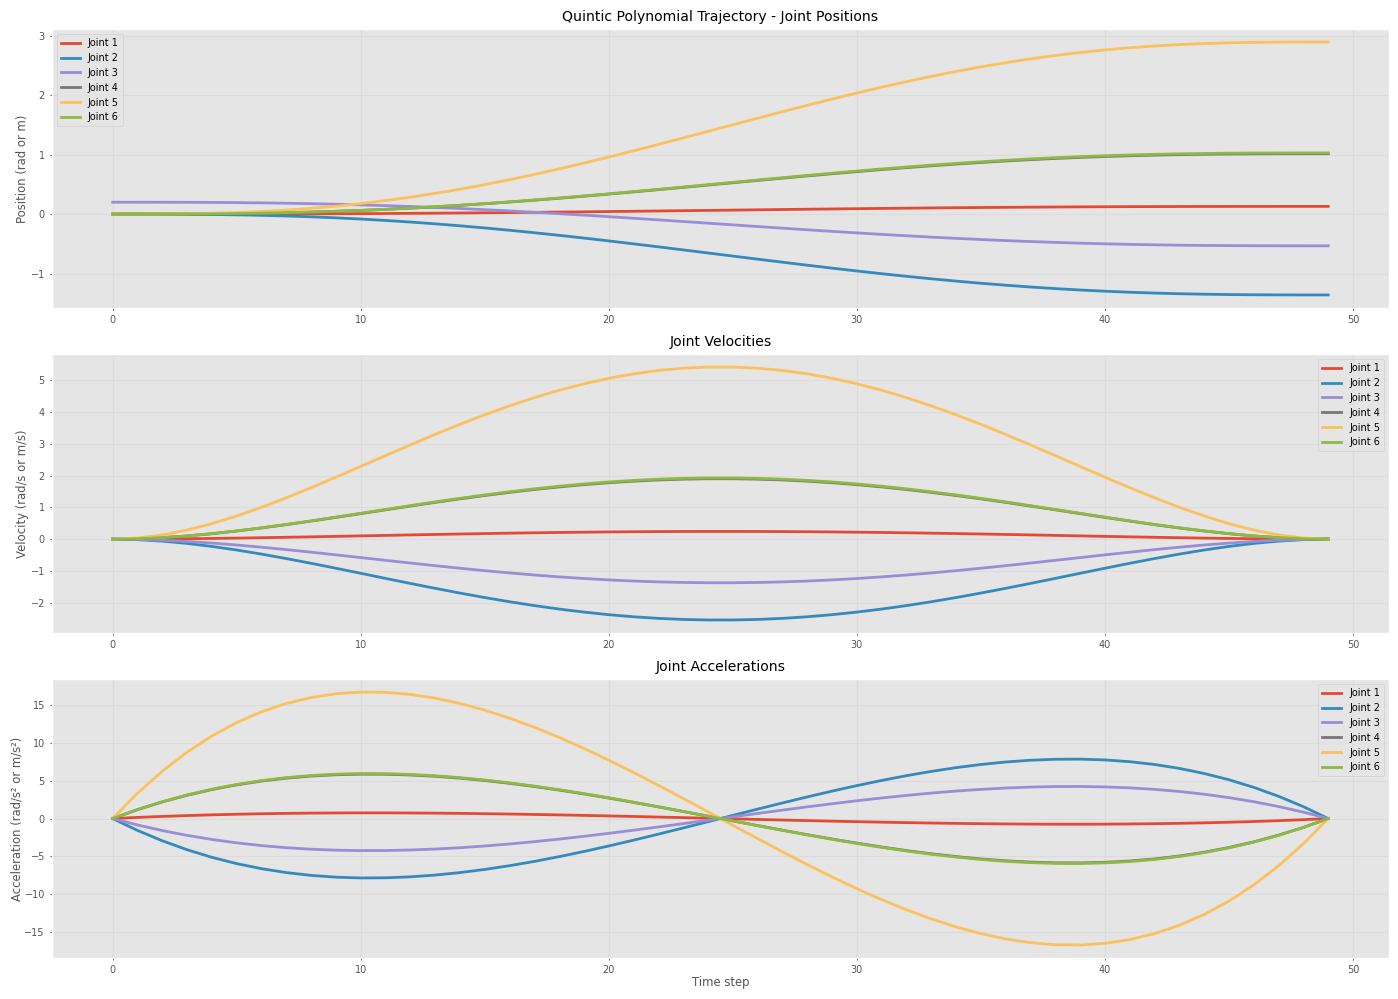

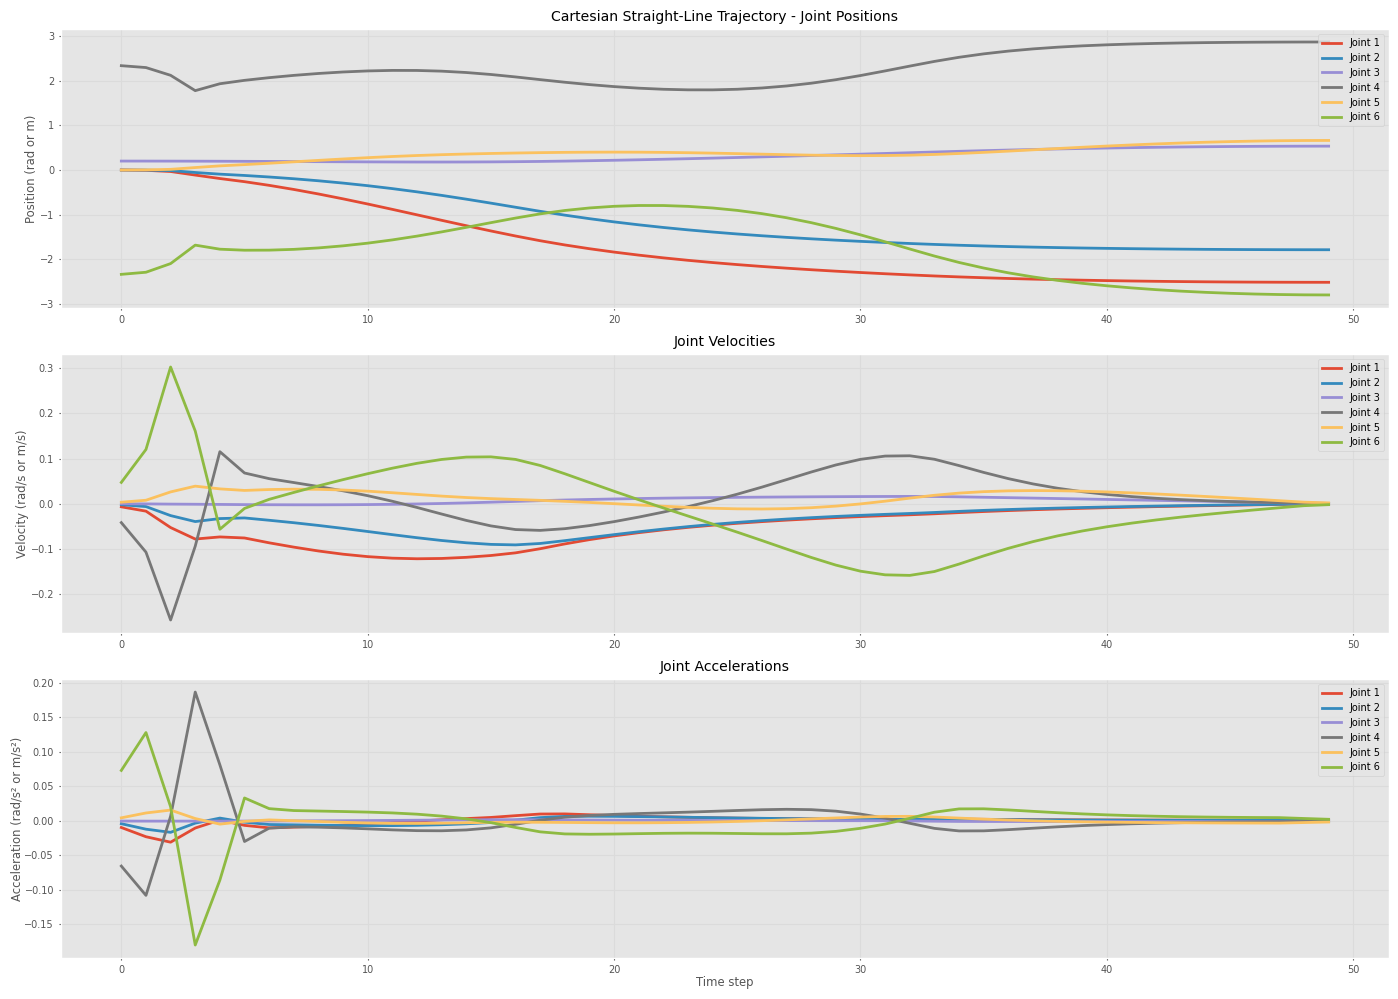

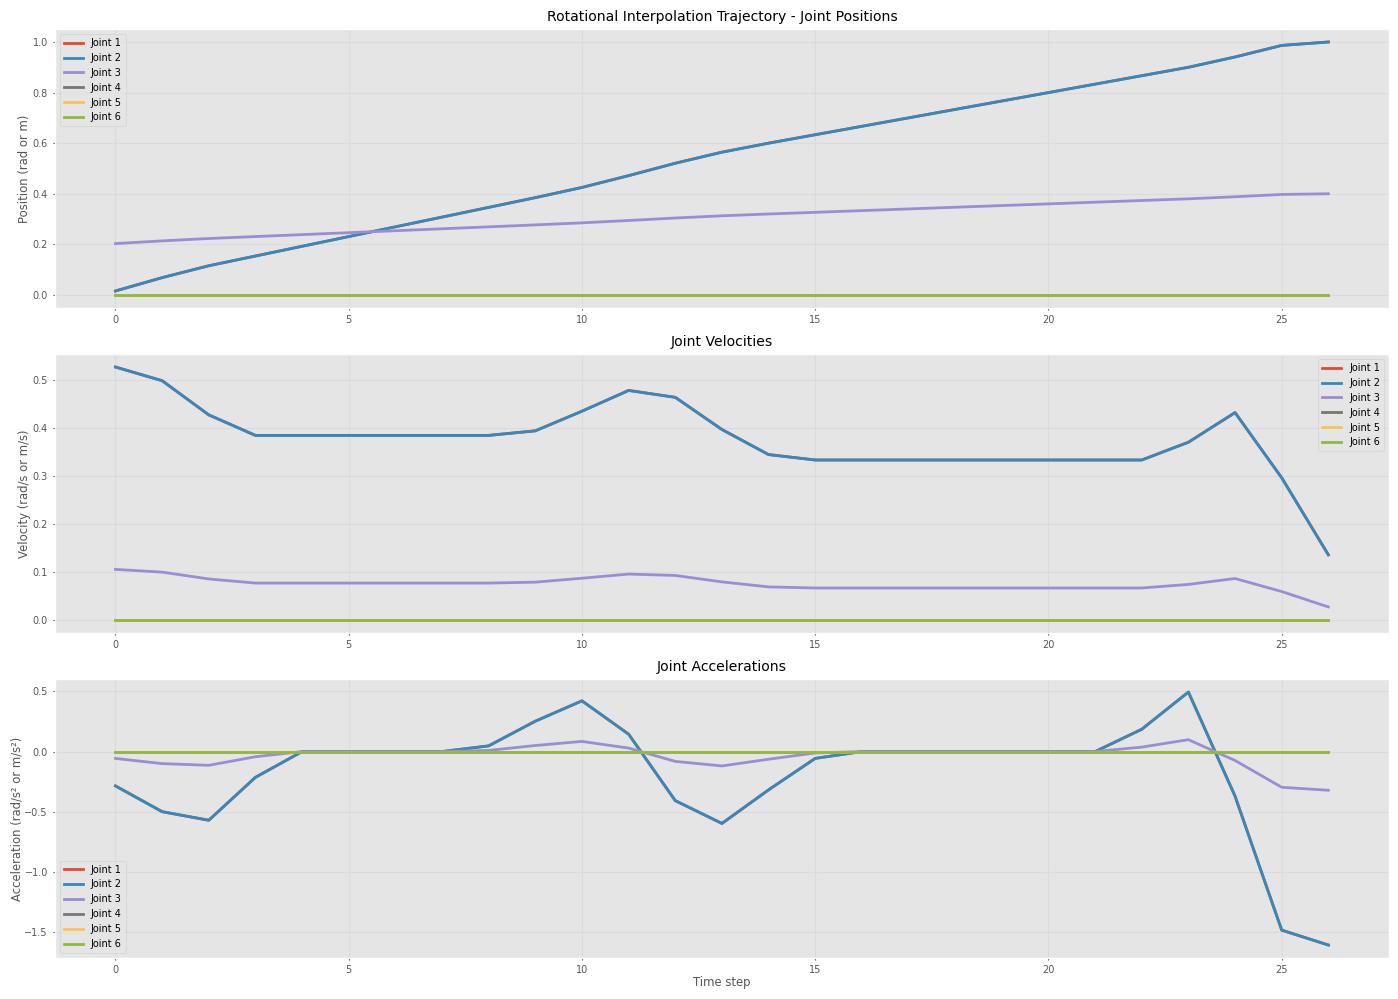

In [10]:
plot_trajectory(traj1, 'Quintic Polynomial Trajectory')
plot_trajectory(traj2, 'Cartesian Straight-Line Trajectory')
plot_trajectory(traj3, 'Rotational Interpolation Trajectory')
